In [24]:
#!pip install stable_baselines3

In [25]:
import sys
sys.path.append("C:/Users/snr/kiam_rl")

import numpy as np
from datetime import datetime
import stable_baselines3
from rl_routines import RLProblem, Environment
from rl_routines import ActorCriticNetworks, get_CustomActorCriticPolicy
from rl_routines import evaluate_policy, statistics
import gymnasium as gym
import numpy 
from numpy.linalg import norm
from stable_baselines3 import PPO
import torch
import math
import random
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.tensorboard import SummaryWriter
from scipy.integrate import solve_ivp
from datetime import datetime, timedelta


In [26]:
import sys
sys.path.append(r"C:\Users\snr\kiam_rl\Lens_with_dynamics")

from Lens_with_dynamics.Dynamics_SGLF import Dynamics_SGLF



In [33]:
""" параметры задачи """
# Единицы измерения
V_0 = 0.2
DU = 100_000. # в км
TU = 1e5 # в сек, примерно 27.(7) часов
VU = DU / TU # в км/сек
R0 = 100_000. / DU #радиус круга, который является областью начальных условий;
# движение начинается на расстоянии 550 ае от Солнца
tfinal = 30. * 24. * 60. * 60. / TU # длительность эпизода???
n_imp = 6 # число импульсов за эпизод
delta_t_imp = tfinal / n_imp # интервал между импульсами
delta_v_max = 0.1 / VU # ограничение импульсов
alfa = 1. # весовая константа в выражении для функции вознаграждения
threshold = 0.1 #  в системе единиц, область цели (радиус круга на плоскости Oyz)
total_timesteps = 1500_000 # общее количество шагов во время обучения модели

z = 550 * 1.496e+8 / DU  # Расстояние от Солнца (550 ае)
z0 = 10.0 * 9.461e12 / DU  # Расстояние до барицентра (10 св лет)
DT = 0.05  # Шаг интегрирования
t0 = 0.
# # Орбитальные параметры экзопланеты
Orb_param_exo_array = np.array([
    1. ,  # большая полуось (а.е)
    1. ,  # период обращения (годы)
    0.0167086,  # эксцентриситет
    -240., 352.5, 37.5,  # аргументы орбиты (град)
    datetime(2021, 1, 2)  # начальное время (дата)
])

# Массы тел (в кг)
M_sun = 1.989 * 1e30  # масса Солнца (кг)
M_JSUN_array = np.array([
    1.8982e27,  # Юпитер (кг)
    5.6834e26,  # Сатурн
    8.6810e25,  # Уран
    1.02413e26  # Нептун
])

# Орбитальные параметры планет-гигантов
Orb_param_JSUN_array = np.array([
    [5.2044 , 11.862 , 0.0489, 100.464, 273.867, 1.303, datetime(2023, 1, 21)],  #[a, T, e, Omega, w, i, t0]
    [9.5826 , 29.4571 , 0.0565, 113.665, 339.392, 2.485, datetime(2032, 11, 29)],
    [19.2184 , 84.0205 , 0.046381, 74.006, 96.998857, 0.773, datetime(2050, 8, 19)],
    [30.07, 164.8 , 0.008678, 131.784, 276.336, 1.767957, datetime(2042, 9, 4)]])

In [28]:
class Gravity_Problem(RLProblem): # задача БЕЗ динамики!!!
    def __init__(self, R0, tfinal, n_imp, delta_t_imp, delta_v_max, alfa, threshold ):
        """
        единица расстояния: 100_000 км
        единица скорости: 1 км/сек
        единица времени: 100_000 сек
        """
        super().__init__()
        self.R0 = R0
        self.tfinal = tfinal
        self.nostep = 0  # Счётчик шагов (за эпизод)
        self.n_imp = n_imp
        self.delta_t_imp = delta_t_imp
        self.delta_v_max = delta_v_max
        self.alfa = alfa
        self.threshold = threshold
        self.time_step = self.tfinal / self.n_imp
        self.x_old = None

    @property
    def observation_space(self):  # пространство наблюдений 
        return gym.spaces.Box(low=numpy.array([-numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf, -numpy.inf]),  # low=numpy.array([r_min, v_min])
        high=numpy.array([numpy.inf , numpy.inf, numpy.inf, numpy.inf, numpy.inf, numpy.inf]), # high=numpy.array([r_max, v_max])
        dtype=numpy.float64)
    
    @property
    def action_space(self):  # пространство действий
        #return gym.spaces.Box(low=-self.delta_v_max * 10, high=self.delta_v_max * 10, shape=(3,), dtype=numpy.float32)
        return gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=numpy.float32)
    
    def initialize(self):
        """
        Инициализация начального положения.
        Генерация начального состояния аппарата в соответствии с условиями:
        r0 = [0, y0, z0], v0 = [0, 0, 0], где y0^2 + z0^2 ≤ R0^2.

        Returns
        -------
        t0 : float
            Начальный момент времени (обычно 0).
        x0 : np.ndarray, shape (6,)
            Начальный фазовый вектор (положение и скорость).
            Начальное положение выбирается из области: y0^2 + z0^2 ≤ R0^2.
        """
        self.nostep = 0
        while True:
            y0 = numpy.random.uniform(-self.R0, self.R0) 
            z0 = numpy.random.uniform(-self.R0, self.R0)
            if y0**2 + z0**2 <= self.R0**2:
                break
        r0 = numpy.array([0., y0, z0])
        v0 = numpy.array([0., 0., 0.])
        x0 = numpy.concatenate((r0, v0))
        x0 = numpy.array([0., y0, z0, 0., 0., 0.])
        self.x_old = x0.copy()
        return 0.0, x0
    
    def action2u(self, action):
        """
        Функция, переводящая выход стратегии (нейросети) в импульс.
        Проверяет, что импульс удовлетворяет ограничениям.
        Возвращает импульс (в виде массива [dVx, dVy, dVz]).

        dV: float
            лежит в [-0.1; 0.1]

        """
        #delta_v = numpy.clip(action * self.delta_v_max, -self.delta_v_max, self.delta_v_max) # как в статье
        delta_v = action * min(1, self.delta_v_max/numpy.linalg.norm(action))
        return delta_v
    
    def equations_of_motion(self, t, x):
        """
        Возвращает правую часть уравнений движения dx/dt = f(t, x, u)
        Для текущей задачи размерность x равна 6
        x' = (v, 0, 0, 0)

        Parameters
        ----------
        t : float
            Текущий момент времени
        x : np.ndarray, shape(6,)
            Текущий фазовый вектор x = (r, v)
        
        Returns
        -------
        dx/dt(t, x) : np.ndarray, shape(6,)
            Правая часть уравнений.
            Импульсы тут НЕ учитываются
        """
        return numpy.array([x[3], x[4], x[5], 0., 0., 0.])
    
    def step(self, t, x, delta_v):
        """Шаг 'среды': агент сделал действие, получилось новое состояние"""
        self.x_old = x.copy()
        self.nostep += 1
        x_new = x.copy()
        x_new[3:6] += delta_v  # Учитываем импульс
        x_new = x_new + self.equations_of_motion(t, x_new) * self.time_step
        terminated = False
        truncated = False
        if (self.nostep == self.n_imp):
            truncated = True
        return t + self.time_step, x_new, terminated, truncated

    def rho(self, x):
        """Вычисляет значение ρ(x) по формуле: sqrt(y^2 + z^2) + α * sqrt( (v_y^2 + v_z^2))"""
        y = x[1]
        z =  x[2]  # Компоненты позиции
        vy = x[4]
        vz = x[5]  # Компоненты скорости
        return numpy.sqrt((y)**2 + (z)**2) * (DU / 100_000) + self.alfa * numpy.sqrt(vy**2 + vz**2) * (VU / 1.)

    def reward(self, t, x_new, delta_v,  terminated, truncated):
        reward = 0
        # Вычисляем ρ(x_k) и ρ(x_(k+1))
        rho_old = self.rho(self.x_old)
        rho_new = self.rho(x_new)
        # Вознаграждение за улучшение расстояния (уменьшение ρ)
        r_k = rho_old - rho_new
        reward += r_k
        return reward
    
    def perception_model(self, t, x):   # возвращает вектор наблюдений
        return x



In [29]:
class Dynamics_Problem(RLProblem): # задача С динамикой!!!!!
    def __init__(self, R0, tfinal, n_imp, delta_v_max, alfa, t0, z, z0):
        """
        единица расстояния: 1 а.е.
        единица скорости: 1 а.е.
        единица времени: 1 год
        """
        super().__init__()
        self.R0 = R0 # a.e.
        self.tfinal = tfinal # годы
        self.n_imp = n_imp
        self.time_step = self.tfinal / self.n_imp #интервал между импульсами, год
        self.delta_v_max = delta_v_max # a.e. / год
        self.alfa = alfa # ???
        #self.threshold = threshold # a.e.
        self.t0 = t0 # начало отсчета, год
        self.z0 = z0 # a.e.
        self.z = z # a.e.
        self.nostep = 0 
        self.t0_data = t0_data
        self.dynamics = Dynamics_SGLF(Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array, self.t0, self.t0_data, self.z0)
        
    @property
    def observation_space(self):  
        """
        Размерность вектора наблюдений:
        - Фазовый вектор (6,)
        - Матрица S (3,3) → 9 элементов
        - Первая производная dS/dt (3,3) → 9 элементов
        - Вторая производная d2S/dt2 (3,3) → 9 элементов
        - Ускорение Солнца d^2r_sun/dt^2 (3,)
        Общая размерность: 6 + 9 + 9 + 9 + 3 = 36
        """
        return gym.spaces.Box(
            low=-numpy.inf, high=numpy.inf, shape=(36,), dtype=numpy.float64)
        
    @property
    def action_space(self):  
        return gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=numpy.float32)
    
    def initialize(self):
        """
        Инициализация начального положения и времени.
        Генерация начального состояния аппарата в соответствии с условиями:
        z0 = 550 a.e.
        r0 = [x0, y0, z0], v0 = [0, 0, V0], где x0^2 + y0^2 ≤ R0^2.
        
        Returns
        -------
        t0 : float
            Начальный момент времени (обычно 0).
        x0 : np.ndarray, shape (6,)
            Начальный фазовый вектор (положение и скорость).
            Начальное положение выбирается из области: y0^2 + z0^2 ≤ R0^2.
        """
        start_date = datetime(2000, 1, 2)
        end_date = datetime(2100, 12, 31)
        delta = end_date - start_date
        random_days = random.randint(0, delta.days)
        t0_data_agent = start_date + timedelta(days=random_days)        
        S = self.dynamics.basis_FCS(t = t0_data_agent)[0]
        dS_dt, d2S_dt = self.dynamics.dS_dt(t = t0_data_agent)
        dRdt_SSB_0, d2Rd2t_SSB_0 = self.dynamics.r_sun_deriv(t = 0.)
        self.nostep = 0
        while True:
            x0 = numpy.random.uniform(-self.R0, self.R0) 
            y0 = numpy.random.uniform(-self.R0, self.R0)
            if x0**2 + y0**2 <= self.R0**2:
                break
        p0_FCS = np.array([x0, y0, 0.])
        drdt_SSB_0 = V_0 * S[:, 2]
        dpdt_FCS_0 = S.T @ (drdt_SSB_0 - dRdt_SSB_0 - dS_dt @ p0_FCS)
        X0 = np.concatenate((p0_FCS, dpdt_FCS_0))
        self.X_old = X0.copy()
        return t0_data_agent, X0
    
    def action2u(self, action):
        """
        Функция, переводящая выход стратегии (нейросети) в импульс.
        Проверяет, что импульс удовлетворяет ограничениям.
        Возвращает импульс (в виде массива [dVx, dVy, dVz]).

        dV: float
            лежит в [-0.1; 0.1]
        """
        delta_v = action * min(1, self.delta_v_max / numpy.linalg.norm(action))
        return delta_v
    
    def Dynamics(self, t):
        """
        Возвращает матрицу S и вторую производную по времени от r_sun.
        """
        dynamics = self.dynamics
        dr_sun_dt, d2r_sun_dt = dynamics.r_sun_deriv(t)  
        S, a_vec = dynamics.basis_FCS(t)  
        dS_dt, d2S_dt = dynamics.dS_dt(t)  
        return S, dS_dt, d2S_dt, d2r_sun_dt, a_vec


    def equations_of_motion(self, t, X):
        """
        Возвращает правую часть уравнений движения dx/dt = f(t, x, u)
        Для текущей задачи размерность x равна 6
        x' = (v, f)

        Parameters
        ----------
        t : float
            Текущий момент времени
        x : np.ndarray, shape(6,)
            Текущий фазовый вектор x = (r, v)
        
        Returns
        -------
        dx/dt(t, x) : np.ndarray, shape(6,)
            Правая часть уравнений.
            Импульсы тут НЕ учитываются
        """
        S, dS_dt, d2S_dt, d2r_sun_dt_SSB, a_vec = self.Dynamics(t) 

        p_FCS = X[:3] 
        dpdt_FCS = X[3:]

        D = d2S_dt @ p_FCS + 2 * (dS_dt @ dpdt_FCS)
        d2pdt2_FCS = - S @ d2r_sun_dt_SSB - S.T @ D
        return numpy.concatenate((dpdt_FCS, d2pdt2_FCS), axis=0) 

    def step(self, t, X, delta_v):
        """
        Шаг моделирования: агент применяет импульс, и состояние обновляется.
        """
        if isinstance(t, datetime):
            t = (t - self.t0_data).total_seconds()
            t /= 3600. * 24. * 365.25
        self.X_old = X.copy()
        self.nostep += 1
        X_new = X.copy().astype(numpy.float64)  # Гарантируем, что x_new будет массивом float64
        
        # Применяем изменение скорости к x_new перед интеграцией
        X_new[3:] += delta_v  

        # Численное интегрирование уже с измененной x_new
        sol = solve_ivp(self.equations_of_motion, (t, t + self.time_step), X, method='RK23', t_eval=[t + self.time_step])
        X_new = sol.y[:, -1].copy()
        #X_new[3:] += delta_v 

        terminated = False
        truncated = self.nostep >= self.n_imp 
        #print(f"Шаг {self.nostep}: delta_v = {delta_v}")
        return t + self.time_step, X_new, terminated, truncated

    def rho(self, X):
        """Вычисляет значение ρ(x) по формуле: sqrt(y^2 + z^2) + α * sqrt( (v_y^2 + v_z^2))"""
        x = X[0]
        y = X[1]  # Компоненты позиции
        vx = X[3]
        vy = X[4]  # Компоненты скорости
        #print( "xy ", numpy.sqrt((x)**2 + (y)**2))
        #print("vx vy ", self.alfa * numpy.sqrt(vy**2 + vx**2) )
        return numpy.sqrt((x)**2 + (y)**2) + self.alfa * numpy.sqrt(vy**2 + vx**2) 

    def reward(self, t, X_new, delta_v,  terminated, truncated):
        reward = 0
        # Вычисляем ρ(x_k) и ρ(x_(k+1))
        rho_old = self.rho(self.X_old)
        rho_new = self.rho(X_new)
        # Вознаграждение за улучшение расстояния (уменьшение ρ)
        r_k = rho_old - rho_new
        #r_k = rho_old - rho_new
        reward += r_k
        #print(reward)
        return reward
    
    def perception_model(self, t, X):
        """
        Возвращает полный вектор наблюдений:
        - текущий фазовый вектор (6,)
        - матрица перехода S (9,)
        - её первая производная dS/dt (9,)
        - её вторая производная d2S/dt2 (9,)
        - ускорение Солнца d^2r_sun/dt^2 (3,)
        """
        S, dS_dt, d2S_dt, d2r_sun_dt, _ = self.Dynamics(t)

        # Преобразуем матрицы в одномерные массивы
        S_flat = S.flatten()
        dS_dt_flat = dS_dt.flatten()
        d2S_dt_flat = d2S_dt.flatten()
        
        observation = np.concatenate((X, S_flat, dS_dt_flat, d2S_dt_flat, d2r_sun_dt))
        return observation
    

In [30]:
model_no_dynamics = PPO.load("C:/Users/snr/kiam_rl/train_gravity1.zip")

problem_no_dynamics = Gravity_Problem(R0=R0, tfinal = tfinal, n_imp = n_imp, delta_t_imp = delta_t_imp, delta_v_max = delta_v_max, alfa = alfa, threshold = threshold)
env_no_dynamics = DummyVecEnv([lambda: Monitor(Environment(problem_no_dynamics))])

In [31]:
t0_data = datetime(2030, 9, 1, 0, 0)
problem_with_dynamics = Dynamics_Problem(R0=R0, tfinal = tfinal, n_imp = n_imp, delta_v_max = delta_v_max, alfa = alfa, t0=t0,  z0=z0, z = z)
env_with_dynamics = DummyVecEnv([lambda: Monitor(Environment(problem_with_dynamics))])

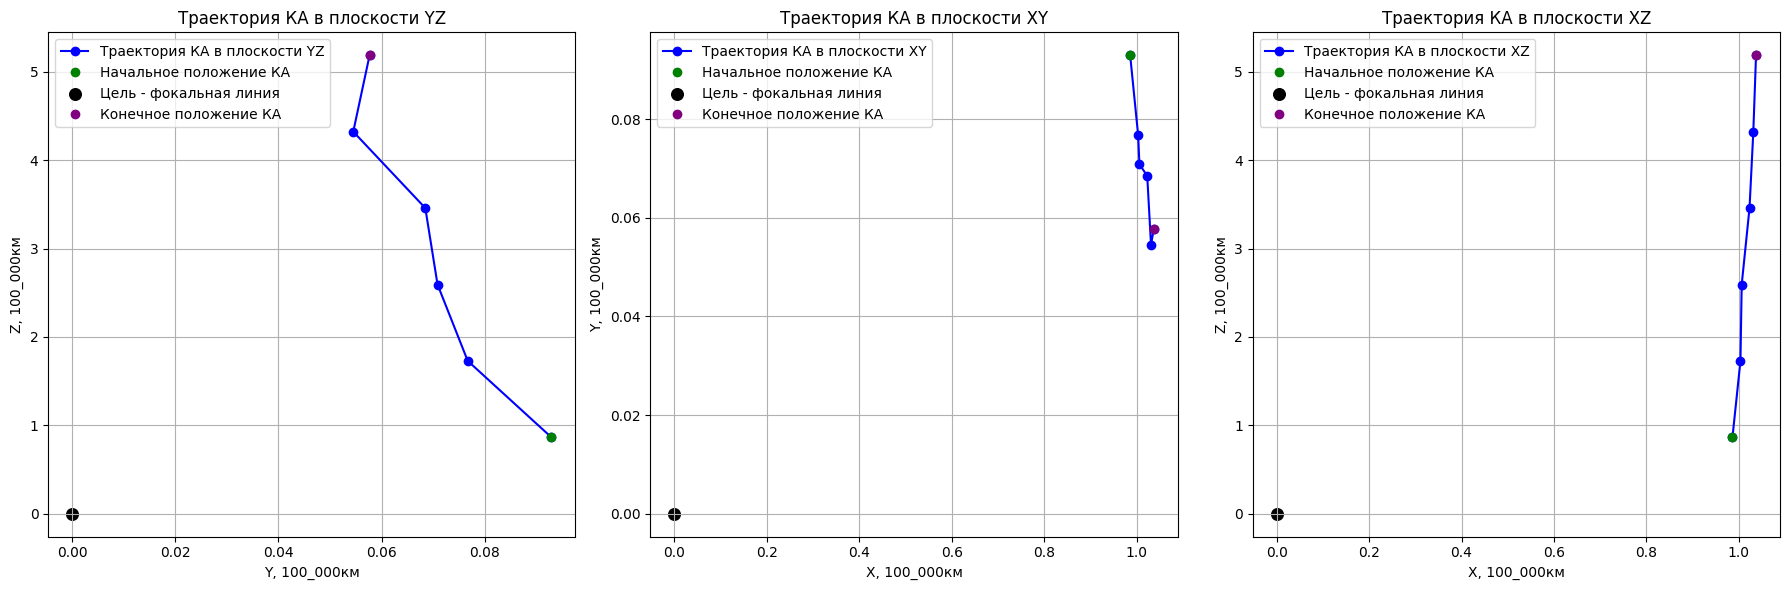

In [47]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Загружаем модель PPO
model_no_dynamics = PPO.load("C:/Users/snr/kiam_rl/train_gravity1.zip")

# Определяем вашу задачу (например, проблема гравитации)
problem_no_dynamics = Gravity_Problem(R0=R0, tfinal=tfinal, n_imp=n_imp, delta_t_imp=delta_t_imp, delta_v_max=delta_v_max, alfa=alfa, threshold=threshold)

# Оборачиваем окружение
env_no_dynamics = DummyVecEnv([lambda: Monitor(Environment(problem_no_dynamics))])

# Инициализация окружения
obs = env_no_dynamics.reset()  # Начальное состояние

# Инициализация списков для хранения данных
action_array = []
states_array = []
obs_array = []
rewards_array = []
reward_total = 0.
reward_total_array = []
t_array=[]  
X_array=[]
t1,X1 = problem_no_dynamics.initialize()
t,X = problem_with_dynamics.initialize()

# Цикл по шагам
for i in range(n_imp):
    # Получаем данные наблюдения из перцептивной модели
    obs = problem_with_dynamics.perception_model(t, X)[:6]

    # Модель предсказывает действие
    action, _states = model_no_dynamics.predict(obs, deterministic=True)

    # Применяем действие
    delta_v = problem_no_dynamics.action2u(action)

    # Выполняем шаг
    t, X, terminated, truncated = problem_with_dynamics.step(t, X, delta_v)
    
    # Сохраняем данные
    obs_array.append(obs)
    action_array.append(action)
    states_array.append([t, X])
    t_array.append(t)  # Сохраняем t отдельно
    X_array.append(X)

    # Подсчитываем награду (можно настроить систему вознаграждений)
    reward_total += 1  # Временно, замените на свою систему вознаграждений
    rewards_array.append(1)  # Аналогично
    reward_total_array.append(reward_total)

    # Проверка завершения эпизода
    if terminated or truncated:
        dones = [True]
        break
    else:
        dones = [False]

# Преобразуем t_array и X_array в NumPy массивы
t_array = np.array(t_array)
X_array = np.array(X_array)

# Теперь у вас будут два массива: t_array и X_array
# Извлекаем координаты и скорости
x_array = X_array[:, 0]
y_array = X_array[:,1]
z_array = X_array[:,2]
vx_array = X_array[:,3]
vy_array = X_array[:,4]
vz_array = X_array[:,5]
# Визуализация траектории
fig = plt.figure(figsize=(18, 6))

# 2D-график в плоскости (y, z)
ax1 = fig.add_subplot(131)
ax1.plot(y_array, z_array, '-o', color='blue', label='Траектория КА в плоскости YZ')
ax1.plot(y_array[0], z_array[0], 'o', color="green", label="Начальное положение КА")
ax1.scatter([0.], [0.], color='black', s=70, label="Цель - фокальная линия")
ax1.plot(y_array[-1], z_array[-1], 'o', color="purple", label="Конечное положение КА")
ax1.set_title('Траектория КА в плоскости YZ')
ax1.set_xlabel('Y, 100_000км')
ax1.set_ylabel('Z, 100_000км')
ax1.legend()
ax1.grid()

# 2D-график в плоскости (x, y)
ax2 = fig.add_subplot(132)
ax2.plot(x_array, y_array, '-o', color='blue', label='Траектория КА в плоскости XY')
ax2.plot(x_array[0], y_array[0], 'o', color="green", label="Начальное положение КА")
ax2.scatter([0.], [0.], color='black', s=70, label="Цель - фокальная линия")
ax2.plot(x_array[-1], y_array[-1], 'o', color="purple", label="Конечное положение КА")
ax2.set_title('Траектория КА в плоскости XY')
ax2.set_xlabel('X, 100_000км')
ax2.set_ylabel('Y, 100_000км')
ax2.legend()
ax2.grid()

# 2D-график в плоскости (x, z)
ax3 = fig.add_subplot(133)
ax3.plot(x_array, z_array, '-o', color='blue', label='Траектория КА в плоскости XZ')
ax3.plot(x_array[0], z_array[0], 'o', color="green", label="Начальное положение КА")
ax3.scatter([0.], [0.], color='black', s=70, label="Цель - фокальная линия")
ax3.plot(x_array[-1], z_array[-1], 'o', color="purple", label="Конечное положение КА")
ax3.set_title('Траектория КА в плоскости XZ')
ax3.set_xlabel('X, 100_000км')
ax3.set_ylabel('Z, 100_000км')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()


In [45]:
z_array

array([0.86387827, 1.72772989, 2.59181245, 3.45542873, 4.31918982,
       5.1831463 ])

In [61]:
import numpy as np

V_0 = 0.2 
num_episodes = 100  

initial_distances = []
final_distances = []
initial_speeds = []
final_speeds = []
u_total = []  # Суммарные затраты характеристической скорости
delta_r_f = []  # Промахи по положению
delta_v_f = []  # Промахи по скорости

for episode in range(num_episodes):
    obs = env_with_dynamics.reset()  # Сброс окружения для нового эпизода
    done = False

    # Обнуление переменных состояния
    t, X = problem_with_dynamics.initialize()  

    # Массивы для хранения данных по эпизоду
    episode_distances = []
    episode_speeds = []
    episode_u = 0  

    for i in range(n_imp):
        # Получаем данные наблюдения из перцептивной модели
        obs = problem_with_dynamics.perception_model(t, X)[:6]

        # Проверяем размерность obs
        if obs.ndim == 1:  # Ожидается одномерный массив
            x, y, z = obs[0], obs[1], obs[2]
            vx, vy, vz = obs[3], obs[4], obs[5]
        elif obs.ndim == 2:  # Ожидается форма (1, N), берем первую строку
            x, y, z = obs[0, 0], obs[0, 1], obs[0, 2]
            vx, vy, vz = obs[0, 3], obs[0, 4], obs[0, 5]
        else:
            raise ValueError(f"Неподдерживаемая размерность obs: {obs.shape}")

        # Модель предсказывает действие
        action, _states = model_no_dynamics.predict(obs, deterministic=True)

        # Применяем действие
        delta_v = 0. * problem_no_dynamics.action2u(action)

        # # Проверяем норму delta_v перед масштабированием
        # if np.linalg.norm(delta_v) > 0:
        #     delta_v = delta_v * min(1, delta_v_max / np.linalg.norm(delta_v))

        # Выполняем шаг динамики
        t, X, terminated, truncated = problem_with_dynamics.step(t, X, delta_v)

        # Вычисляем расстояние и скорость
        distance_to_focal = np.sqrt(x**2 + y**2)
        speed_to_focal = np.sqrt(vx**2 + vy**2)

        # Накопление данных
        episode_u += np.linalg.norm(delta_v)
        episode_distances.append(distance_to_focal)
        episode_speeds.append(speed_to_focal)

        # Проверка завершения эпизода
        if terminated or truncated:
            break

    # Сохраняем начальные и конечные значения эпизода
    if len(episode_distances) > 0:  # Проверяем, что есть данные
        initial_distances.append(episode_distances[0])
        final_distances.append(episode_distances[-1])
        initial_speeds.append(episode_speeds[0])
        final_speeds.append(episode_speeds[-1])
        u_total.append(episode_u)

# Преобразование списков в массивы
delta_r_f = np.array(final_distances) * DU
delta_v_f = np.array(final_speeds) * VU * 1000.
u_total = np.array(u_total) * VU * 1000.

# Вывод статистики
print('∆rf, км:', np.mean(delta_r_f), '±', np.std(delta_r_f))
print('∆vf, м/с:', np.mean(delta_v_f), '±', np.std(delta_v_f))
print('u, м/с:', np.mean(u_total), '±', np.std(u_total))


∆rf, км: 64242.94314813182 ± 22768.63645792546
∆vf, м/с: 3.4016563407084055 ± 1.351102961260073
u, м/с: 0.0 ± 0.0


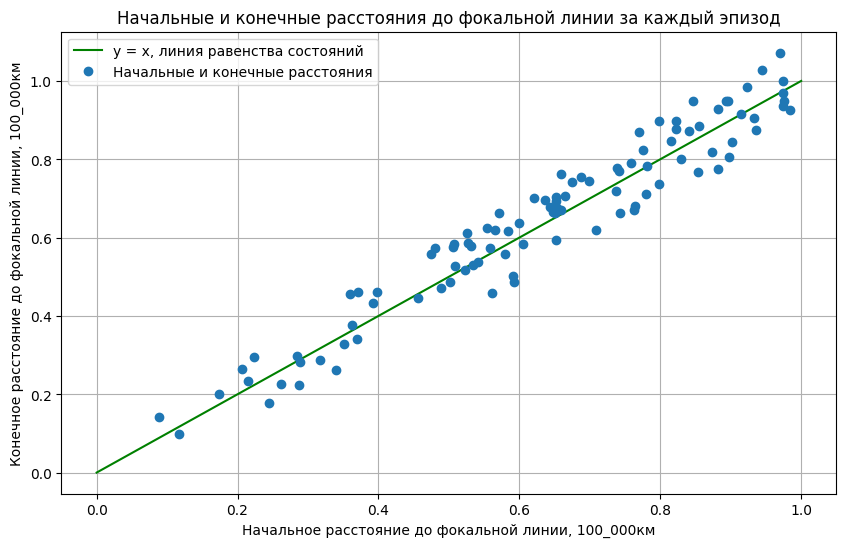

In [62]:
x = np.linspace(0, 1, 100) 
y = x
initial_distances = np.array(initial_distances) 
final_distances = np.array(final_distances) 
plt.figure(figsize=(10, 6))
plt.plot(x, y, label = "y = x, линия равенства состояний", color = 'green')
plt.plot( initial_distances , final_distances , 'o', label="Начальные и конечные расстояния")
plt.xlabel("Начальное расстояние до фокальной линии, 100_000км")
plt.ylabel("Конечное расстояние до фокальной линии, 100_000км")
plt.title("Начальные и конечные расстояния до фокальной линии за каждый эпизод")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# СТАРАЯ ЗАДАЧА

# Загрузка модели
model_no_dynamics = PPO.load("C:/Users/snr/kiam_rl/train_gravity1.zip")

# Инициализация задачи
problem_no_dynamics = Gravity_Problem(R0=R0, tfinal=tfinal, n_imp=n_imp, delta_t_imp=delta_t_imp, delta_v_max=delta_v_max, alfa=alfa, threshold=threshold)

# Инициализация окружения
env_no_dynamics = DummyVecEnv([lambda: Monitor(Environment(problem_no_dynamics))])

# Задание количества эпизодов
num_episodes_old = 5000  # ??? 

# Инициализация переменных для сбора данных
initial_distances_old = []
final_distances_old = []
initial_speeds_old = []
final_speeds_old = []
u_total_old = []  # Суммарные затраты характеристической скорости
delta_r_f_old = []  # Промахи по положению
delta_v_f_old = []  # Промахи по скорости

# Начало тренировочного процесса
for episode_old in range(num_episodes_old):
    obs_old = env_no_dynamics.reset()  # Сброс окружения для нового эпизода
    done_old = False
    t_old, X_old = problem_no_dynamics.initialize()  # Инициализация задачи
    
    # Массивы для хранения данных по каждому эпизоду
    episode_distances_old = []
    episode_speeds_old = []
    episode_u_old = 0  # Суммарные затраты скорости для эпизода
    
    for i_old in range(n_imp):
        action_old, _states_old = model_no_dynamics.predict(obs_old, deterministic=True)
        obs_old, rewards_old, dones_old, info_old = env_no_dynamics.step(action_old)
        
        if dones_old[0]:  # Если эпизод завершен
            obs_old = info_old[0]['terminal_observation']
            obs_old = np.array([obs_old])

        # Получаем данные из состояния
        y_old = obs_old[0, 1]  
        z_old = obs_old[0, 2]  
        vy_old = obs_old[0, 4]  
        vz_old = obs_old[0, 5] 
        distance_to_focal_old = np.sqrt(y_old**2 + z_old**2)
        speed_to_focal_old = np.sqrt(vy_old**2 + vz_old**2)
        
        # Расчет изменения скорости
        delta_v_old = action_old * min(1, delta_v_max / np.linalg.norm(action_old))
        episode_u_old += np.linalg.norm(delta_v_old)
        
        # Сохраняем данные для эпизода
        episode_distances_old.append(distance_to_focal_old)
        episode_speeds_old.append(speed_to_focal_old)
        
    # Сохраняем начальные и конечные значения для эпизода
    initial_distances_old.append(episode_distances_old[0])
    final_distances_old.append(episode_distances_old[-1])
    initial_speeds_old.append(episode_speeds_old[0])
    final_speeds_old.append(episode_speeds_old[-1])
    u_total_old.append(episode_u_old)

# Преобразование в нужные единицы
delta_r_f_old = np.array(final_distances_old) * DU
delta_v_f_old = np.array(final_speeds_old) * VU * 1000
u_total_old = np.array([u_total_old]) * VU * 1000

# Вывод статистики
print('∆rf, км:', statistics(delta_r_f_old))
print('∆vf, м/с:', statistics(delta_v_f_old))
print('u, м/с:', statistics(u_total_old))



∆rf, км: (106.58490175991032, 1892.3180794392413, 2648.926539602521, 3187.256171063506, 6543.483949284631, 2626.930857673988, 1017.5584067715829, 2.581602038951726)
∆vf, м/с: (0.1854736232206305, 13.41174589232471, 19.76459150055911, 25.0900167717882, 37.058141469348705, 19.12033661917854, 7.692658370564865, 2.485530449699998)
u, м/с: (68.93226283136755, 82.91825733613223, 91.08208934776485, 96.95450041908771, 107.41561371833086, 89.5981583300163, 9.306321655433125, 9.627666187285499)


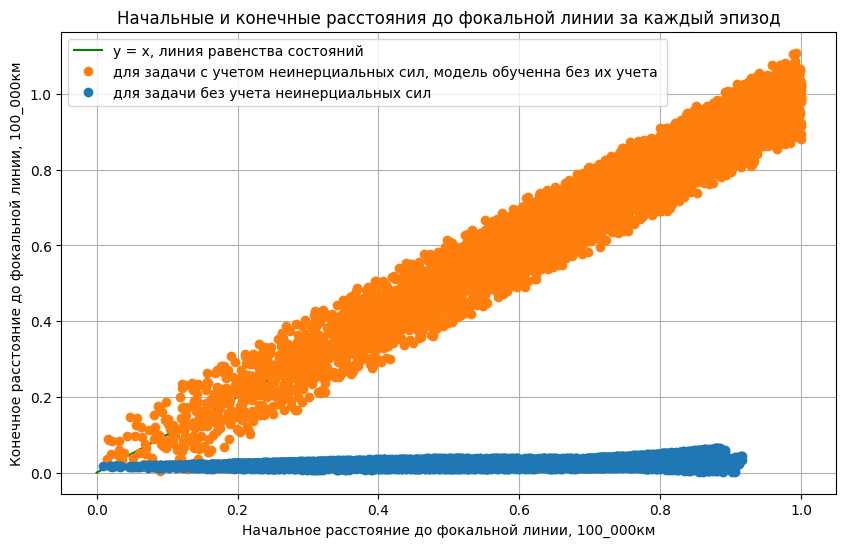

In [57]:
x = np.linspace(0, 1, 100) 
y = x
initial_distances = np.array(initial_distances) 
final_distances = np.array(final_distances) 
plt.figure(figsize=(10, 6))
plt.plot(x, y, label = "y = x, линия равенства состояний", color = 'green')
plt.plot( initial_distances , final_distances , 'o',  color = 'tab:orange', label="для задачи с учетом неинерциальных сил, модель обученна без их учета ")
plt.plot( initial_distances_old , final_distances_old, 'o', color = 'tab:blue', label="для задачи без учета неинерциальных сил")
plt.xlabel("Начальное расстояние до фокальной линии, 100_000км")
plt.ylabel("Конечное расстояние до фокальной линии, 100_000км")
plt.title("Начальные и конечные расстояния до фокальной линии за каждый эпизод")
plt.legend()
plt.grid(True)
plt.show()
